# 🧩 OFDM Fundamentals

--> **Author:** Rahul Gulia  
--> **Ph.D. Student**  
--> **Rochester Institute of Technology**


## Key Points:

1. Multi-carrier modulation: OFDM divides a high-rate data stream into multiple low-rate substreams distributed over orthogonal carriers.
2. Orthogonal signals: In OFDM, sub-carriers are spaced at intervals delta_f = 1/T, where T is the symbol duration

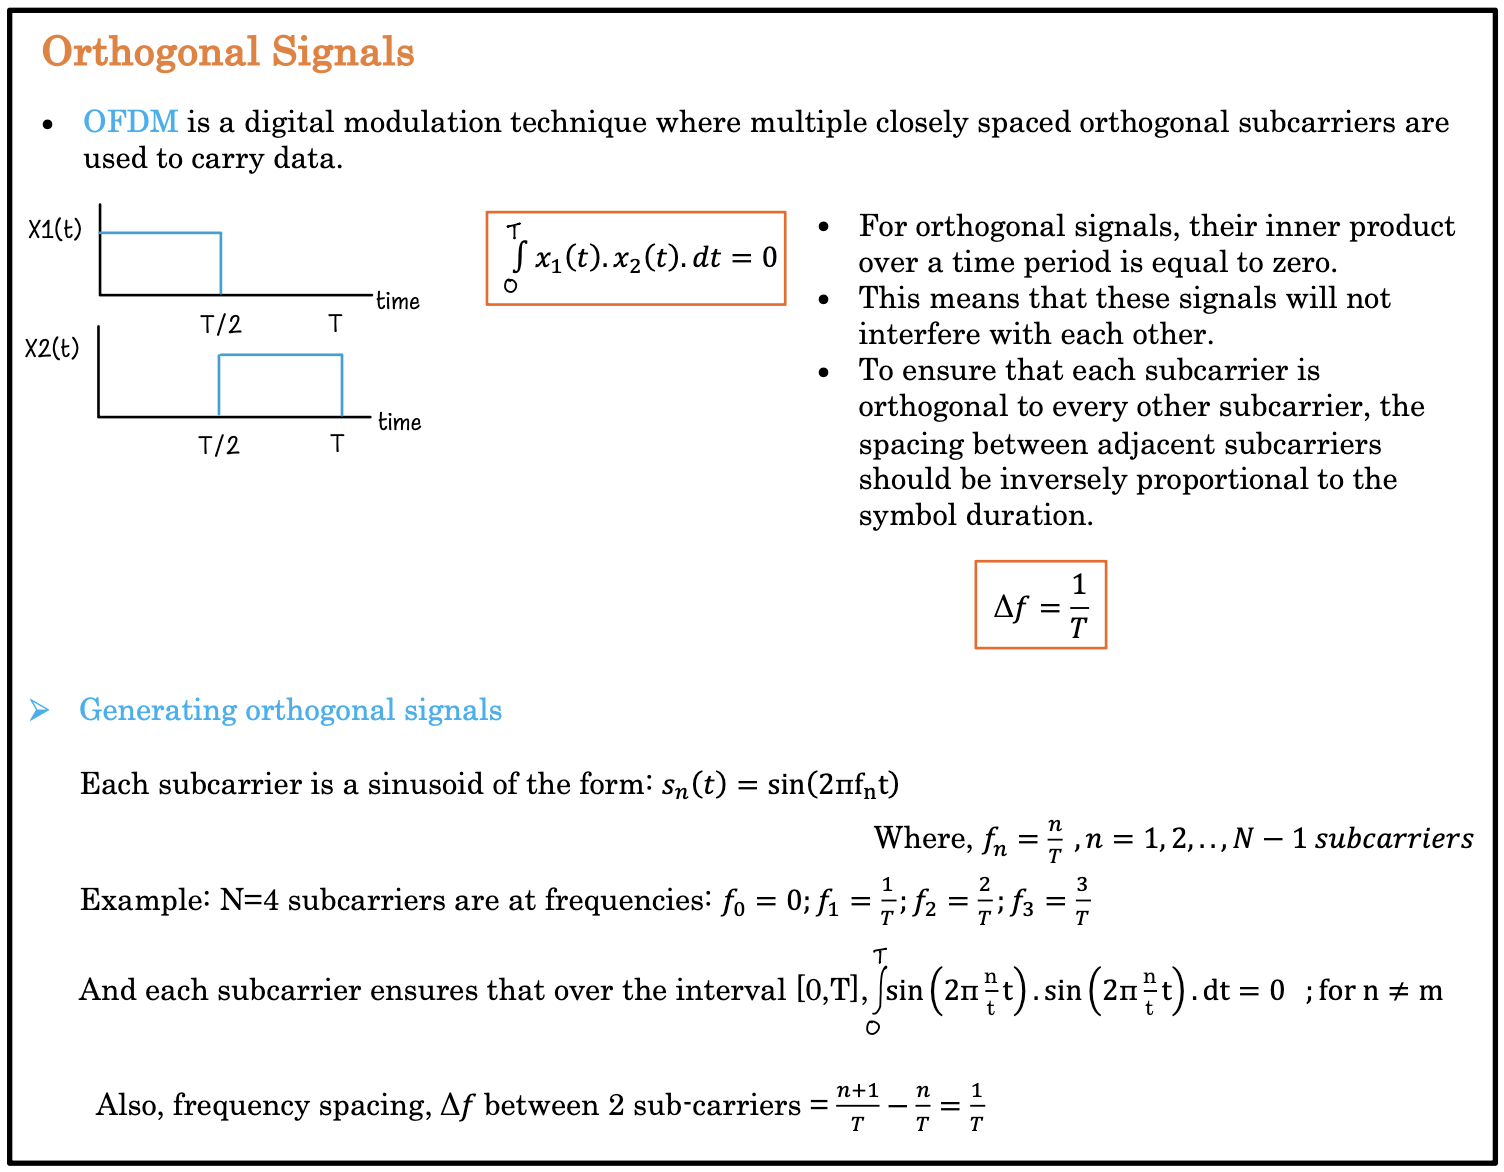

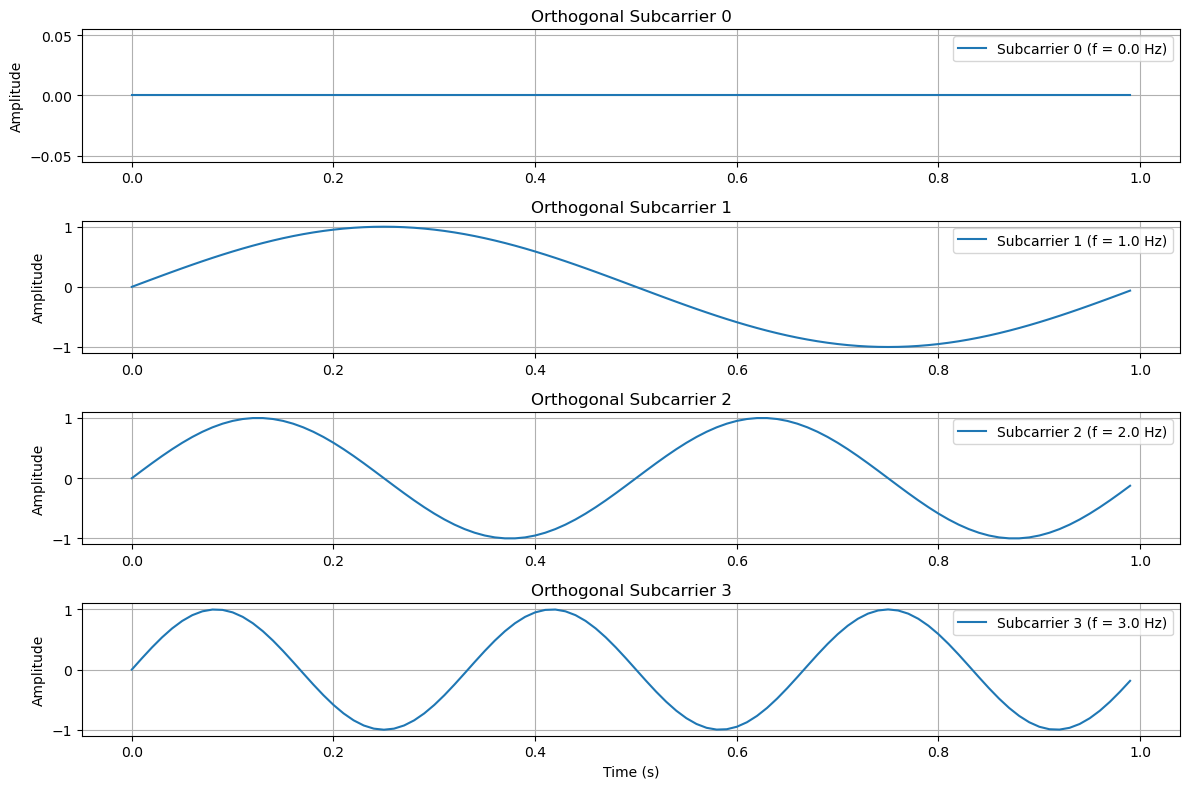

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1  # symbol duration (seconds)
N = 4  # number of subcarriers
fs = 100  # sampling frequency
t = np.linspace(0, T, int(T * fs), endpoint=False)

# Generate orthogonal subcarriers
subcarriers = [np.sin(2 * np.pi * n / T * t) for n in range(N)]

# Plot the subcarriers
plt.figure(figsize=(12, 8))
for i, carrier in enumerate(subcarriers):
    plt.subplot(N, 1, i + 1)
    plt.plot(t, carrier, label=f'Subcarrier {i} (f = {i/T:.1f} Hz)')
    plt.title(f'Orthogonal Subcarrier {i}')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()


* After learning about the orthogonal signals, lets dive into OFDM 

# OFDM: Transmitting random bits

SNR:  0 dB | BER: 3.653e-01 | ✗
SNR:  2 dB | BER: 3.281e-01 | ✗
SNR:  4 dB | BER: 2.950e-01 | ✗
SNR:  6 dB | BER: 2.536e-01 | ✗
SNR:  8 dB | BER: 2.180e-01 | ✗
SNR: 10 dB | BER: 1.831e-01 | ✗
SNR: 12 dB | BER: 1.677e-01 | ✗
SNR: 14 dB | BER: 1.417e-01 | ✗
SNR: 16 dB | BER: 1.318e-01 | ✗
SNR: 18 dB | BER: 1.219e-01 | ✗
SNR: 20 dB | BER: 1.135e-01 | ✗
SNR: 22 dB | BER: 1.132e-01 | ✗
SNR: 24 dB | BER: 1.106e-01 | ✗
SNR: 26 dB | BER: 1.099e-01 | ✗
SNR: 28 dB | BER: 1.097e-01 | ✗
SNR: 30 dB | BER: 1.081e-01 | ✗
SNR: 32 dB | BER: 1.080e-01 | ✗
SNR: 34 dB | BER: 1.075e-01 | ✗
SNR: 36 dB | BER: 1.062e-01 | ✗
SNR: 38 dB | BER: 1.063e-01 | ✗
SNR: 40 dB | BER: 1.071e-01 | ✗
SNR: 42 dB | BER: 1.065e-01 | ✗
SNR: 44 dB | BER: 1.069e-01 | ✗
SNR: 46 dB | BER: 1.065e-01 | ✗
SNR: 48 dB | BER: 1.066e-01 | ✗


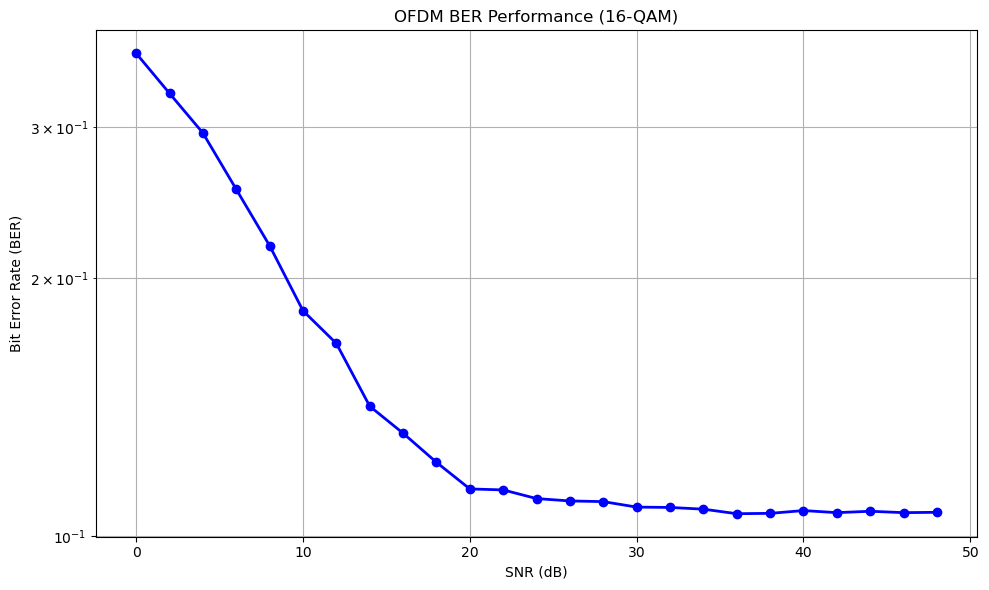

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

def ofdm_simulation():
    # Simulation parameters
    num_bits = 10000
    mod_scheme = '16-QAM'
    N = 64                  # Number of subcarriers
    CP = 16                 # Cyclic prefix length
    pilot_positions = [0, 16, 32, 48]
    snr_db_values = np.arange(0, 50, 2)  # Reasonable SNR range

    # Modulation config
    config = {
        'QPSK': {
            'bits': 2,
            'symbols': np.array([1+1j, -1+1j, -1-1j, 1-1j]) / np.sqrt(2)
        },
        '16-QAM': {
            'bits': 4,
            'symbols': np.array([
                -3-3j, -3-1j, -3+3j, -3+1j,
                -1-3j, -1-1j, -1+3j, -1+1j,
                 3-3j,  3-1j,  3+3j,  3+1j,
                 1-3j,  1-1j,  1+3j,  1+1j
            ]) / np.sqrt(10)  # Normalize average power to 1
        }
    }
    cfg = config[mod_scheme]

    # Generate random bitstream (ensure it's a multiple of bits per symbol)
    tx_bits = np.random.randint(0, 2, num_bits)
    extra_bits = len(tx_bits) % cfg['bits']
    if extra_bits != 0:
        tx_bits = tx_bits[:-extra_bits]

    # Map bits to symbols
    reshaped_bits = tx_bits.reshape(-1, cfg['bits'])
    symbol_indices = np.array([int("".join(str(b) for b in row), 2) for row in reshaped_bits])
    tx_symbols = cfg['symbols'][symbol_indices]

    ber_results = []

    for snr_db in snr_db_values:
        # Padding symbols to fill complete OFDM blocks
        symbols = np.copy(tx_symbols)
        if len(symbols) % N != 0:
            pad = N - len(symbols) % N
            symbols = np.concatenate([symbols, np.zeros(pad, dtype=complex)])

        ofdm_blocks = symbols.reshape(-1, N)

        # Insert pilots
        pilot_symbol = 1 + 1j
        ofdm_blocks[:, pilot_positions] = pilot_symbol

        # IFFT and add Cyclic Prefix
        time_blocks = np.fft.ifft(ofdm_blocks, axis=1)
        time_blocks_cp = np.concatenate([time_blocks[:, -CP:], time_blocks], axis=1)
        tx_signal = time_blocks_cp.flatten()

        # Channel (multipath + AWGN)
        channel_taps = np.array([1.0, 0.0, 0.3])
        channel_taps = channel_taps / np.linalg.norm(channel_taps)  # Normalize energy
        rx_signal = np.convolve(tx_signal, channel_taps, mode='same')  # Apply multipath
        signal_power = np.mean(np.abs(rx_signal)**2)
        noise_power = signal_power / (10**(snr_db/10))
        noise = np.sqrt(noise_power/2) * (np.random.randn(len(rx_signal)) + 1j*np.random.randn(len(rx_signal)))
        rx_signal += noise  # Add AWGN *after* channel

        # Receiver: Reshape & Remove CP
        rx_blocks = rx_signal.reshape(-1, N + CP)
        rx_blocks = rx_blocks[:, CP:]  # Remove CP
        rx_symbols_blocks = np.fft.fft(rx_blocks, axis=1)

        # Channel Estimation (pilot-based)
        H_est = np.ones_like(rx_symbols_blocks)
        for pos in pilot_positions:
            H_est[:, pos] = rx_symbols_blocks[:, pos] / pilot_symbol

        # Interpolate channel response across all subcarriers
        x = np.arange(N)
        for i in range(H_est.shape[0]):
            H_real = interpolate.interp1d(pilot_positions, H_est[i, pilot_positions].real, kind='linear', fill_value="extrapolate")(x)
            H_imag = interpolate.interp1d(pilot_positions, H_est[i, pilot_positions].imag, kind='linear', fill_value="extrapolate")(x)
            H_est[i] = H_real + 1j * H_imag

        # Equalize
        rx_eq = rx_symbols_blocks / H_est
        rx_eq = rx_eq.flatten()[:len(tx_symbols)]  # Trim padding

        # Symbol Detection
        distances = np.abs(rx_eq[:, None] - cfg['symbols'][None, :])
        detected_indices = np.argmin(distances, axis=1)

        # Convert symbol indices back to bits
        rx_bits = np.array([np.binary_repr(i, width=cfg['bits']) for i in detected_indices])
        rx_bits = np.array([list(map(int, b)) for b in rx_bits]).flatten()

        # Compute BER
        min_len = min(len(tx_bits), len(rx_bits))
        ber = np.mean(tx_bits[:min_len] != rx_bits[:min_len])
        ber_results.append(ber)
        print(f"SNR: {snr_db:2d} dB | BER: {ber:.3e} | {'✓' if ber < 0.1 else '✗'}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.semilogy(snr_db_values, ber_results, 'bo-', linewidth=2, markersize=6)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.title(f'OFDM BER Performance ({mod_scheme})')
    plt.grid(True, which='both')
    plt.tight_layout()
    plt.show()

ofdm_simulation()


# OFDM Model: Transmitting an image file


                                Input Data → Modulation (QAM/PSK) → Serial to Parallel → IFFT → Add Cyclic Prefix
                                                                       ↓

                                                Channel (with multipath fading and noise)
                                                                       ↓

                                Output Data ← Demodulation ← Parallel to Serial ← FFT ← Remove Cyclic Prefix


--- Calculating BER vs SNR for Modulation: BPSK ---
SNR: 0 dB, BER: 1.91e-01 (BPSK)
SNR: 2 dB, BER: 1.35e-01 (BPSK)
SNR: 4 dB, BER: 9.68e-02 (BPSK)
SNR: 6 dB, BER: 7.74e-02 (BPSK)
SNR: 8 dB, BER: 7.22e-02 (BPSK)
SNR: 10 dB, BER: 7.15e-02 (BPSK)
SNR: 12 dB, BER: 7.14e-02 (BPSK)
SNR: 14 dB, BER: 7.14e-02 (BPSK)
SNR: 16 dB, BER: 7.14e-02 (BPSK)
SNR: 18 dB, BER: 7.14e-02 (BPSK)
SNR: 20 dB, BER: 7.14e-02 (BPSK)
SNR: 22 dB, BER: 7.14e-02 (BPSK)
SNR: 24 dB, BER: 7.14e-02 (BPSK)
SNR: 26 dB, BER: 7.14e-02 (BPSK)
SNR: 28 dB, BER: 7.14e-02 (BPSK)
SNR: 30 dB, BER: 7.14e-02 (BPSK)
SNR: 32 dB, BER: 7.14e-02 (BPSK)
SNR: 34 dB, BER: 7.14e-02 (BPSK)
SNR: 36 dB, BER: 7.14e-02 (BPSK)
SNR: 38 dB, BER: 7.14e-02 (BPSK)

--- Calculating BER vs SNR for Modulation: QPSK ---
SNR: 0 dB, BER: 2.77e-01 (QPSK)
SNR: 2 dB, BER: 2.19e-01 (QPSK)
SNR: 4 dB, BER: 1.67e-01 (QPSK)
SNR: 6 dB, BER: 1.25e-01 (QPSK)
SNR: 8 dB, BER: 9.71e-02 (QPSK)
SNR: 10 dB, BER: 8.43e-02 (QPSK)
SNR: 12 dB, BER: 8.04e-02 (QPSK)
SNR: 14 dB, B

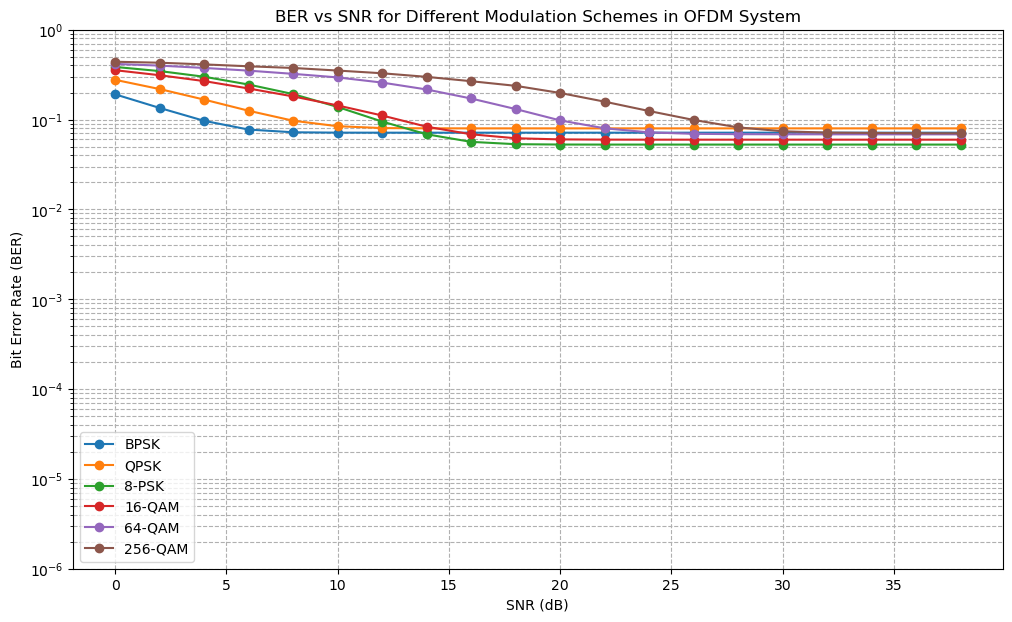


--- Reconstructing Image with Modulation: BPSK at SNR = 30 dB ---

--- Reconstructing Image with Modulation: QPSK at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 8-PSK at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 16-QAM at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 64-QAM at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 256-QAM at SNR = 30 dB ---


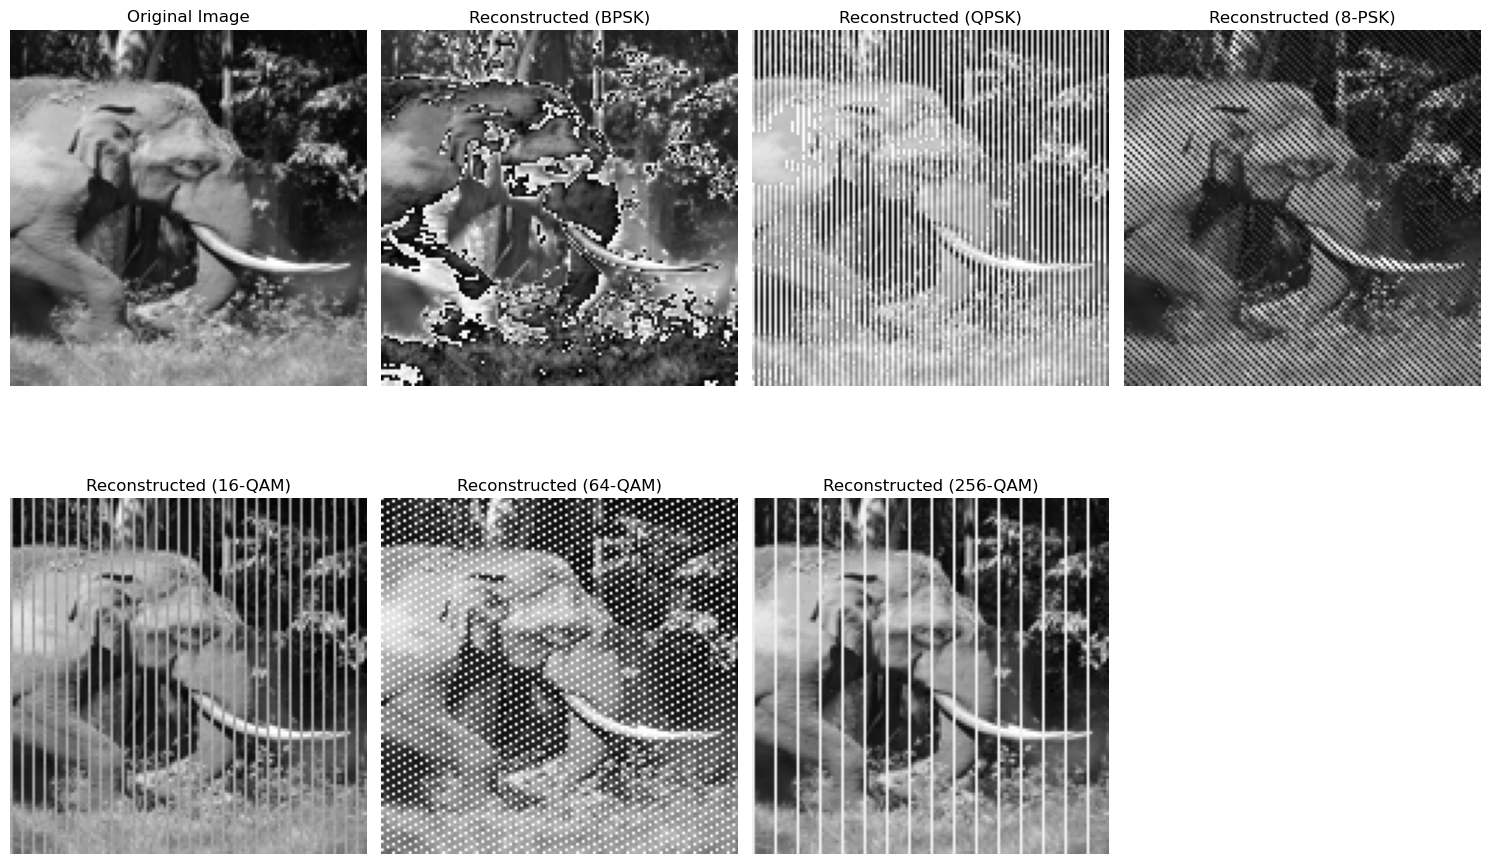

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import interpolate

# === Helper Functions (helper_function.py - Integrated) ===
def get_modulation_config(mod_scheme):
    if mod_scheme == 'BPSK':
        return {'bits_per_symbol': 1, 'constellation': np.array([-1+0j, 1+0j])}
    elif mod_scheme == 'QPSK':
        return {'bits_per_symbol': 2, 'constellation': np.array([-1-1j, -1+1j, 1-1j, 1+1j]) / np.sqrt(2)}
    elif mod_scheme == '8-PSK':
        return {'bits_per_symbol': 3, 'constellation': np.exp(1j * np.arange(0, 2 * np.pi, 2 * np.pi / 8))}
    elif mod_scheme == '16-QAM':
        return {'bits_per_symbol': 4, 'constellation': np.array([-3-3j, -3-1j, -3+3j, -3+1j,
                                                                 -1-3j, -1-1j, -1+3j, -1+1j,
                                                                  3-3j,  3-1j,  3+3j,  3+1j,
                                                                  1-3j,  1-1j,  1+3j,  1+1j]) / np.sqrt(10)}
    elif mod_scheme == '64-QAM':
        levels = [-7, -5, -3, -1, 1, 3, 5, 7]
        constellation = np.array([x + 1j * y for y in levels for x in levels]) / np.sqrt(42)
        return {'bits_per_symbol': 6, 'constellation': constellation}
    elif mod_scheme == '256-QAM':
        levels = [-15, -13, -11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15]
        constellation = np.array([x + 1j * y for y in levels for x in levels]) / np.sqrt(170)
        return {'bits_per_symbol': 8, 'constellation': constellation}
    else:
        raise ValueError(f"Unsupported modulation scheme: {mod_scheme}")

def modulate_bits(bits, mod_scheme):
    config = get_modulation_config(mod_scheme)
    bits_per_symbol = config['bits_per_symbol']
    constellation = config['constellation']
    num_symbols = len(bits) // bits_per_symbol
    if len(bits) % bits_per_symbol != 0:
        raise ValueError("Number of bits must be a multiple of bits per symbol.")
    indices = bits.reshape(-1, bits_per_symbol).dot(1 << np.arange(bits_per_symbol - 1, -1, -1))
    return constellation[indices]

def demodulate_symbols(symbols, mod_scheme):
    config = get_modulation_config(mod_scheme)
    constellation = config['constellation']
    bits_per_symbol = config['bits_per_symbol']
    demodulated_bits = []
    for symbol in symbols:
        distances = np.abs(constellation - symbol)**2
        closest_index = np.argmin(distances)
        binary_representation = np.binary_repr(closest_index, width=bits_per_symbol)
        demodulated_bits.extend([int(b) for b in binary_representation])
    return np.array(demodulated_bits)

def add_awgn(signal, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / snr_linear
    if np.iscomplexobj(signal):
        noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    else:
        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    return signal + noise

def plot_constellation(received_symbols, transmitted_symbols=None):
    plt.scatter(np.real(received_symbols), np.imag(received_symbols), marker='o', label='Received Symbols')
    if transmitted_symbols is not None:
        plt.scatter(np.real(transmitted_symbols), np.imag(transmitted_symbols), marker='x', color='red', label='Transmitted Symbols')
    plt.xlabel('In-Phase')
    plt.ylabel('Quadrature')
    plt.title('Constellation Diagram')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')

# === Main Script ===
if __name__ == "__main__":
    # === Step 1: Load and Preprocess Image ===
    img_path = "/home/rg9828/Documents/Blogger/Cellular_Modem/Cellular_Modem/pexels-tian-2499271.jpg"
    try:
        img = Image.open(img_path).convert('L')  # Grayscale
        img = img.resize((128, 128))             # Resize image
        img_array = np.array(img)
        binary_data = np.unpackbits(img_array.astype(np.uint8))  # Flatten to 1D binary
    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}. Using random binary data instead.")
        binary_data = np.random.randint(0, 2, 128 * 128 * 8)

    # === Step 2: OFDM Configuration ===
    N = 64  # OFDM subcarriers
    CP = 16
    modulation_schemes = ['BPSK', 'QPSK', '8-PSK', '16-QAM', '64-QAM', '256-QAM']
    snr_db_values = np.arange(0, 40, 2)  # Increased SNR range to accommodate higher modulations
    pilot_positions = np.arange(0, N, 8)  # Increased pilot density
    channel_taps = np.array([0.9, 0.2 * np.exp(-1j * np.pi / 4)]) # More realistic channel

    ber_results_all_schemes = {}

    # === Step 3: BER Calculation for Each Modulation Scheme ===
    for mod_scheme in modulation_schemes:
        print(f"\n--- Calculating BER vs SNR for Modulation: {mod_scheme} ---")
        ber_results = []
        mod_config = get_modulation_config(mod_scheme)
        bits_per_symbol = mod_config['bits_per_symbol']
        num_symbols = len(binary_data) // bits_per_symbol
        tx_bits_original = np.array(binary_data[:num_symbols * bits_per_symbol])
        tx_symbols_original = modulate_bits(tx_bits_original, mod_scheme)

        for snr_db in snr_db_values:
            symbols = np.copy(tx_symbols_original)
            if len(symbols) % N != 0:
                padding_len = N - len(symbols) % N
                symbols = np.concatenate([symbols, np.zeros(padding_len, dtype=complex)])

            num_ofdm_blocks = len(symbols) // N
            ofdm_blocks = symbols.reshape(num_ofdm_blocks, N)
            pilot_value = 1 + 1j
            for block in ofdm_blocks:
                block[pilot_positions] = pilot_value

            time_blocks = np.fft.ifft(ofdm_blocks, axis=1)
            time_blocks_cp = np.concatenate([time_blocks[:, -CP:], time_blocks], axis=1)
            tx_signal = time_blocks_cp.flatten()

            # Channel and Noise
            rx_signal = add_awgn(tx_signal, snr_db)
            rx_signal = np.convolve(rx_signal, channel_taps, mode='same')

            # OFDM Demodulation
            num_rx_blocks = len(rx_signal) // (N + CP)
            if num_rx_blocks * (N + CP) > len(rx_signal):
                num_rx_blocks -= 1
            rx_blocks = rx_signal[:num_rx_blocks * (N + CP)].reshape(-1, N + CP)
            rx_blocks_cp_removed = rx_blocks[:, CP:]
            rx_symbols_blocks_noisy = np.fft.fft(rx_blocks_cp_removed, axis=1)

            # Channel Estimation
            H_est = np.zeros_like(rx_symbols_blocks_noisy, dtype=complex)
            pilot_indices = np.array(pilot_positions)
            for block_idx in range(rx_symbols_blocks_noisy.shape[0]):
                received_pilots = rx_symbols_blocks_noisy[block_idx, pilot_indices]
                channel_at_pilots = received_pilots / pilot_value
                interp_real = interpolate.interp1d(pilot_indices, np.real(channel_at_pilots), kind='linear', fill_value="extrapolate")
                interp_imag = interpolate.interp1d(pilot_indices, np.imag(channel_at_pilots), kind='linear', fill_value="extrapolate")
                H_est[block_idx, :] = interp_real(np.arange(N)) + 1j * interp_imag(np.arange(N))

            # Equalization
            rx_symbols_eq_blocks = rx_symbols_blocks_noisy / H_est
            rx_symbols_eq = rx_symbols_eq_blocks.flatten()[:len(tx_symbols_original)]

            # Demodulation
            rx_bits_final = demodulate_symbols(rx_symbols_eq, mod_scheme)[:len(tx_bits_original)]

            # BER Calculation
            ber = np.mean(rx_bits_final != tx_bits_original)
            ber_results.append(ber)
            print(f"SNR: {snr_db} dB, BER: {ber:.2e} ({mod_scheme})")

        ber_results_all_schemes[mod_scheme] = ber_results

    # === Step 4: Plot BER Curves ===
    plt.figure(figsize=(12, 7))
    for mod_scheme, ber_results in ber_results_all_schemes.items():
        plt.semilogy(snr_db_values, ber_results, marker='o', linestyle='-', label=mod_scheme)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.title('BER vs SNR for Different Modulation Schemes in OFDM System')
    plt.grid(True, which="both", ls="--")
    plt.ylim(1e-6, 1)
    plt.legend()
    plt.show()

    # === Step 5: Reconstruct Image for a Fixed SNR ===
    fixed_snr_db = 30  # Increased SNR for higher modulations
    num_rows = 2
    num_cols = 4
    plt.figure(figsize=(15, 10))
    plt.subplot(num_rows, num_cols, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    for i, mod_scheme in enumerate(modulation_schemes):
        print(f"\n--- Reconstructing Image with Modulation: {mod_scheme} at SNR = {fixed_snr_db} dB ---")
        mod_config = get_modulation_config(mod_scheme)
        bits_per_symbol = mod_config['bits_per_symbol']
        num_symbols = len(binary_data) // bits_per_symbol
        tx_bits_original = np.array(binary_data[:num_symbols * bits_per_symbol])
        tx_symbols_original = modulate_bits(tx_bits_original, mod_scheme)

        symbols = np.copy(tx_symbols_original)
        if len(symbols) % N != 0:
            padding_len = N - len(symbols) % N
            symbols = np.concatenate([symbols, np.zeros(padding_len, dtype=complex)])

        num_ofdm_blocks = len(symbols) // N
        ofdm_blocks = symbols.reshape(num_ofdm_blocks, N)
        pilot_value = 1 + 1j
        for block in ofdm_blocks:
            block[pilot_positions] = pilot_value

        time_blocks = np.fft.ifft(ofdm_blocks, axis=1)
        time_blocks_cp = np.concatenate([time_blocks[:, -CP:], time_blocks], axis=1)
        tx_signal = time_blocks_cp.flatten()

        # Channel and Noise
        rx_signal = add_awgn(tx_signal, fixed_snr_db)
        rx_signal = np.convolve(rx_signal, channel_taps, mode='same')

        # OFDM Demodulation
        num_rx_blocks = len(rx_signal) // (N + CP)
        if num_rx_blocks * (N + CP) > len(rx_signal):
            num_rx_blocks -= 1
        rx_blocks = rx_signal[:num_rx_blocks * (N + CP)].reshape(-1, N + CP)
        rx_blocks_cp_removed = rx_blocks[:, CP:]
        rx_symbols_blocks_noisy = np.fft.fft(rx_blocks_cp_removed, axis=1)

        # Channel Estimation
        H_est = np.zeros_like(rx_symbols_blocks_noisy, dtype=complex)
        pilot_indices = np.array(pilot_positions)
        for block_idx in range(rx_symbols_blocks_noisy.shape[0]):
            received_pilots = rx_symbols_blocks_noisy[block_idx, pilot_indices]
            channel_at_pilots = received_pilots / pilot_value
            interp_real = interpolate.interp1d(pilot_indices, np.real(channel_at_pilots), kind='linear', fill_value="extrapolate")
            interp_imag = interpolate.interp1d(pilot_indices, np.imag(channel_at_pilots), kind='linear', fill_value="extrapolate")
            H_est[block_idx, :] = interp_real(np.arange(N)) + 1j * interp_imag(np.arange(N))

        # Equalization
        rx_symbols_eq_blocks = rx_symbols_blocks_noisy / H_est
        rx_symbols_eq = rx_symbols_eq_blocks.flatten()[:len(tx_symbols_original)]

        # Demodulation
        rx_bits_final = demodulate_symbols(rx_symbols_eq, mod_scheme)[:len(tx_bits_original)]
        rx_bits_padded = np.pad(rx_bits_final, (0, binary_data.size - len(rx_bits_final)), 'constant')
        rx_bits_packed = np.packbits(rx_bits_padded)
        rx_image_array = rx_bits_packed[:128*128].reshape((128, 128))
        rx_image = Image.fromarray(rx_image_array.astype(np.uint8))

        # Plot Reconstructed Image
        plt.subplot(num_rows, num_cols, i + 2)
        plt.imshow(rx_image, cmap='gray')
        plt.title(f"Reconstructed ({mod_scheme})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

SyntaxError: invalid syntax (2974477041.py, line 1)